# Compute IP/EA with NWChem
Check on how the calculations are doing. What the run times are, what fractions have completed, etc.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.simulate.qcfractal import GeometryDataset, SolvationEnergyDataset, HessianDataset, compute_ionization_potentials
import pandas as pd
import numpy as np

RDKit WARNING: [13:48:34] Enabling RDKit 2019.09.3 jupyter extensions


## Get the Geometries
Gather the XTB geometries

In [2]:
dataset = GeometryDataset('Electrolyte Geometry NWChem, 6-31G(2df,p)', 'normal_basis')

Print out the general status

In [3]:
dataset.coll.status()

,normal_basis
INCOMPLETE,4542
COMPLETE,4008
ERROR,640


Review the completed geometries

In [4]:
%%time
geoms = dataset.get_energies()
print(f'Completed {sum(map(len, geoms.values()))} geometries of {len(geoms)} molecules')
print(f'All ionic states computed for {sum(map(lambda x: len(x) == 3, geoms.values()))} molecules')

Completed 4008 geometries of 2541 molecules
All ionic states computed for 530 molecules
CPU times: user 2.94 s, sys: 39.2 ms, total: 2.98 s
Wall time: 7.14 s


Plot the runtimes

In [5]:
runtimes = dataset.coll.df['normal_basis'].apply(lambda x: x.provenance.wall_time if x.status.value == "COMPLETE" else None)

In [6]:
runtimes = runtimes[runtimes != None]

Print statistics in minutes

In [7]:
(runtimes / 60).describe()

count    4008.000000
mean       26.069214
std        26.166067
min         0.515426
25%         9.223044
50%        15.520816
75%        34.289908
max       296.620826
Name: normal_basis, dtype: float64

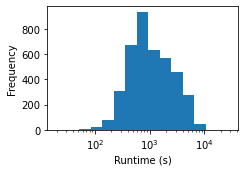

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

min_ = np.log10(runtimes.min())
max_ = np.log10(runtimes.max())
ax.hist(runtimes, bins=np.logspace(min_ - 0.2, max_ + 0.2, 16))

ax.set_xscale('log')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Frequency')

fig.tight_layout()

In [9]:
wts = dataset.get_wall_times()

## Review the ZPE Calculations
We ran Hessian calculations for each geometry

In [10]:
hess = HessianDataset('Electrolyte Hessian, 6-31G(2df,p)', 'nwchem', 'normal_basis')

In [11]:
zpes = hess.get_zpe()
print(f'Computed {sum(map(len, zpes.values()))} ZPEs')

/home/wardlt/UC/JCESR/edw/moldesign/simulate/thermo.py:97: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  temps = temps[np.array(temps.to("K")) > 300.]
/home/wardlt/miniconda3/envs/edw/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


Computed 2463 ZPEs


Get the runtimes

In [12]:
records = hess.get_complete_records()
runtimes = hess.get_complete_records().apply(lambda x: x.provenance.wall_time)

Print statistics in minutes

In [13]:
(runtimes / 60).describe()

count    2463.000000
mean       18.968233
std        10.715211
min         1.199869
25%        10.803378
50%        16.346139
75%        25.792332
max        76.412573
Name: record, dtype: float64

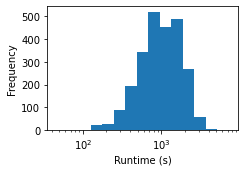

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

min_ = np.log10(runtimes.min())
max_ = np.log10(runtimes.max())
ax.hist(runtimes, bins=np.logspace(min_ - 0.2, max_ + 0.2, 16))

ax.set_xscale('log')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Frequency')

fig.tight_layout()

## Review the Solvation Energy Calculations
Compute the solvation energies for all of the molecules

In [15]:
solv_dataset = SolvationEnergyDataset('EDW NWChem Solvation Energy, 6-31G(2df,p)', 'nwchem', 'normal_basis')

Pull down a summary

In [16]:
%%time
solv_energies = solv_dataset.get_energies()
solv_df = solv_dataset.coll.get_values()
print(f'Completed {(~solv_df.isnull()).values.sum()} solvation energies '
      f'of {len(solv_energies)} molecules')

Completed 0.0 solvation energies of 0 molecules
CPU times: user 53.1 ms, sys: 21 µs, total: 53.1 ms
Wall time: 50.4 ms


## Generate Redox Properties
Compute the redox properties with and without ZPE

In [17]:
redox_data = compute_ionization_potentials(dataset, solv_dataset)

RDKit WARNING: [13:50:21] Cannot assign bond directions!


Load in Gaussian data for comparison

In [18]:
gaussian_data = pd.read_csv('datasets/gaussian-redox.csv')

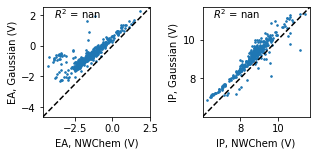

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.25))

merged_data = redox_data.merge(gaussian_data, on='inchi_key', suffixes=['_nwc', '_g09'])

for l, ax in zip(['EA', 'IP'], axs):
    xtb = merged_data[f'{l}_nwc']
    g09 = merged_data[f'{l}_g09']
    r2 = np.corrcoef(xtb, g09)[0, 1] ** 2
    ax.scatter(xtb, g09, s=2.5)
    ax.text(0.1, 0.9, f'$R^2$ = {r2:.2f}', transform=ax.transAxes)

    min_ = min(ax.get_xlim()[0], ax.get_ylim()[0])
    max_ = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(min_, max_)
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

    ax.set_xlabel(f'{l}, NWChem (V)')
    ax.set_ylabel(f'{l}, Gaussian (V)')
fig.tight_layout()

In [20]:
redox_data.to_csv('datasets/normal-basis_no-zpe_redox.csv', index=False)

Repeat, but with ZPE

In [21]:
redox_data = compute_ionization_potentials(dataset, solv_dataset, hess)

/home/wardlt/UC/JCESR/edw/moldesign/simulate/thermo.py:97: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  temps = temps[np.array(temps.to("K")) > 300.]
/home/wardlt/miniconda3/envs/edw/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


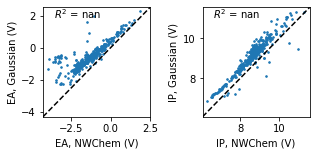

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.25))

merged_data = redox_data.merge(gaussian_data, on='inchi_key', suffixes=['_nwc', '_g09'])

for l, ax in zip(['EA', 'IP'], axs):
    xtb = merged_data[f'{l}_nwc']
    g09 = merged_data[f'{l}_g09']
    r2 = np.corrcoef(xtb, g09)[0, 1] ** 2
    ax.scatter(xtb, g09, s=2.5)
    ax.text(0.1, 0.9, f'$R^2$ = {r2:.2f}', transform=ax.transAxes)

    min_ = min(ax.get_xlim()[0], ax.get_ylim()[0])
    max_ = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(min_, max_)
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

    ax.set_xlabel(f'{l}, NWChem (V)')
    ax.set_ylabel(f'{l}, Gaussian (V)')
fig.tight_layout()

In [23]:
redox_data.to_csv('datasets/normal-basis_redox.csv', index=False)